# Recriar Estudo 6

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-24 19:58:22.490517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 19:58:23.617582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4274518960948463347
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4475371037894647184
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-24 19:58:25.270350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.392468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.392524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.554163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.554240: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-24 19:58:25.568581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.568705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:25.568743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-24 19:58:26.473101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:26.473208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:26.473245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:26.473528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 19:58:26.473544: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']   

## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 1478
  Classe 0 (Sem fogo): 448 imagens (30.31%)
  Classe 1 (Fogo): 1030 imagens (69.69%)
----------------------------------------
📊 VAL -> Total de imagens: 165
  Classe 0 (Sem fogo): 50 imagens (30.30%)
  Classe 1 (Fogo): 115 imagens (69.70%)
----------------------------------------
📊 TEST -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [16]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('Recriar_Estudo_6_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


2025-06-24 19:58:46.157227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-24 19:58:47.550980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-24 19:58:49.030510: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8368069310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-24 19:58:49.030559: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-24 19:58:49.080755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-24 19:58:49.356502: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

93/93 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9186 - f1_score: 0.8326
Epoch 1: val_loss improved from inf to 0.85202, saving model to Recriar_Estudo_6_best.h5
93/93 [==============================] - 22s 123ms/step - loss: 0.3658 - accuracy: 0.8444 - precision: 0.8444 - recall: 0.8444 - auc: 0.9186 - f1_score: 0.8326 - val_loss: 0.8520 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3673 - val_f1_score: 0.2326 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9867 - f1_score: 0.9566
Epoch 2: val_loss did not improve from 0.85202
93/93 [==============================] - 10s 97ms/step - loss: 0.1675 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9867 - f1_score: 0.9566 - val_loss: 0.9782 - val_accuracy: 0.3030 - val_precision: 0.3030 - val_recall: 0.3030 - val_auc: 0.3030 - val_f1_score: 0.2326 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/50
92/93 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9963 - f1_score: 0.9778
Epoch 3: val_loss did not improve from 0.85202
93/93 [==============================] - 10s 97ms/step - loss: 0.0929 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9963 - f1_score: 0.9779 - val_loss: 1.1622 - val_accuracy: 0.3030 - val_precision: 0.

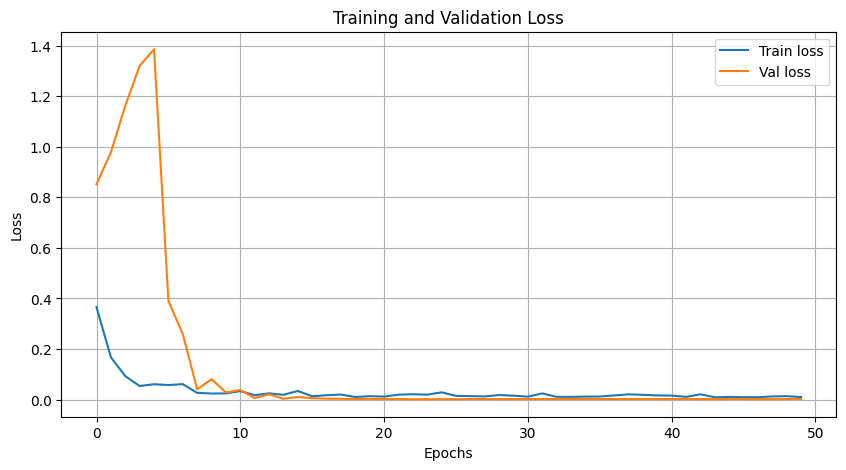

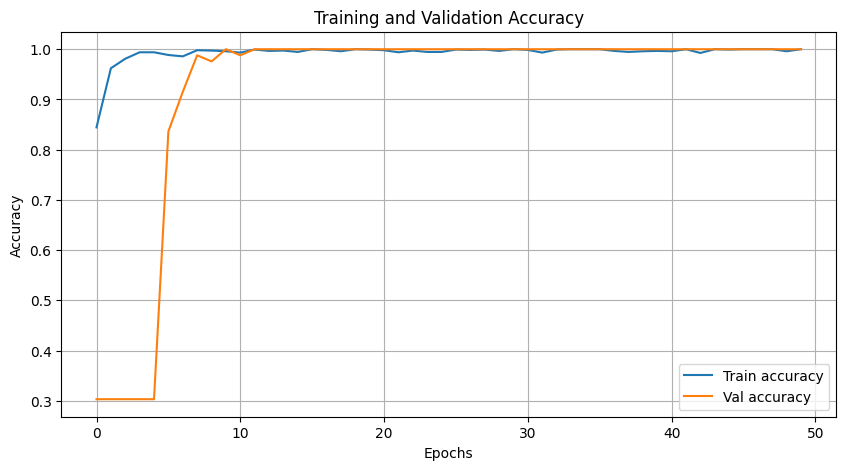

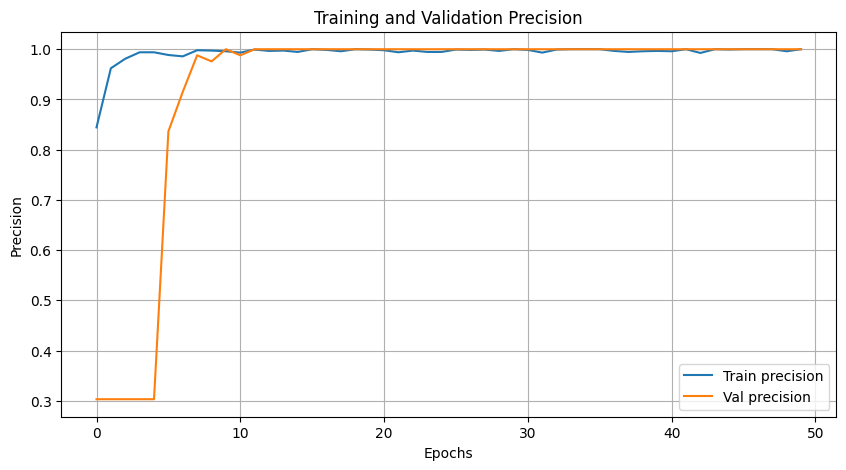

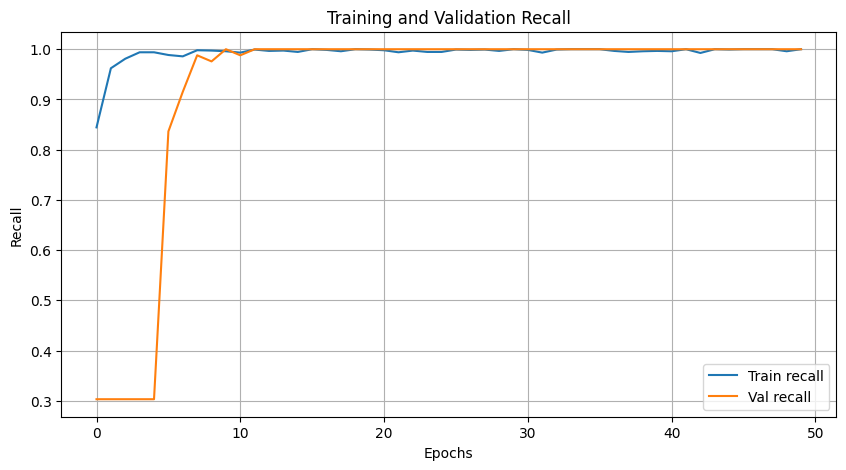

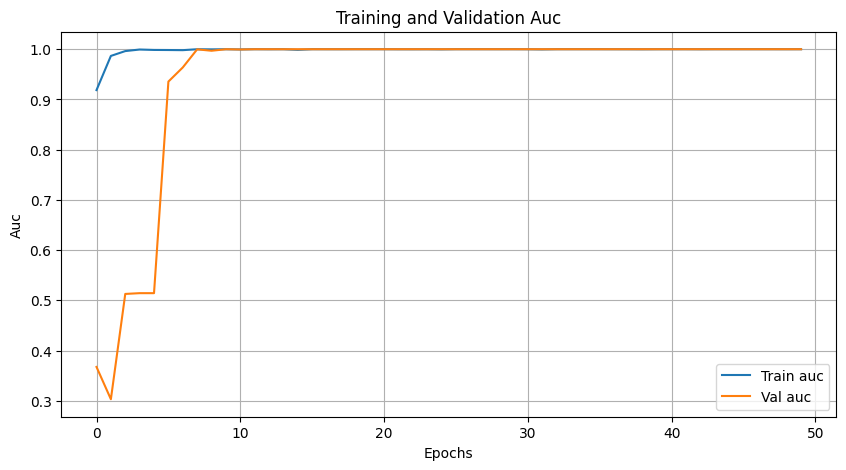

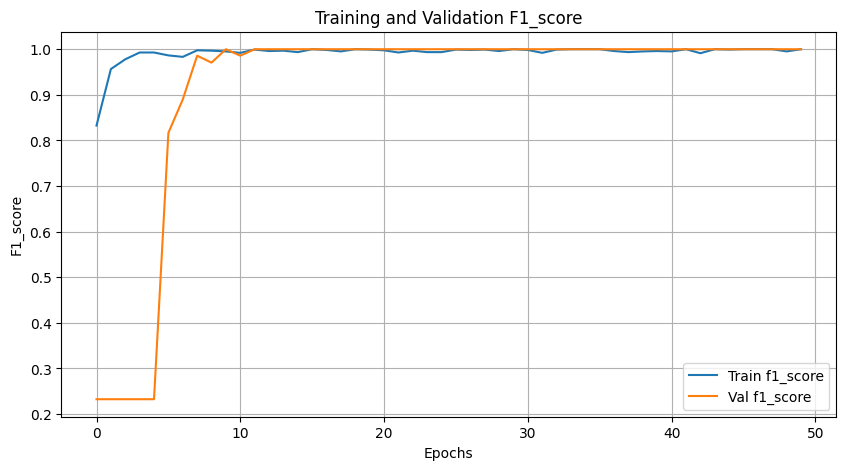

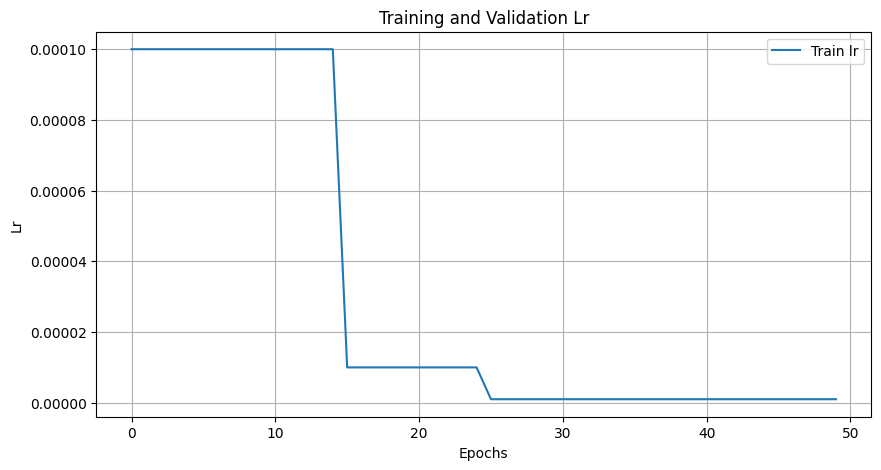

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_6_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_6.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7667, TN=7780, FP=0, FN=113
Accuracy       : 0.9927
Precision      : 1.0000
Recall         : 0.9855
F1-Score       : 0.9927
AUC            : 0.9999
Binary Loss    : 0.0313
FDR (Fire Detection Rate)      : 98.55 %
EWR (Error Warning Rate)       : 0.73 %
Confusion Matrix:
[[7780    0]
 [ 113 7667]]


{'TP': 7667,
 'TN': 7780,
 'FP': 0,
 'FN': 113,
 'accuracy': 0.9927377892030849,
 'precision': 1.0,
 'recall': 0.9854755784061696,
 'f1_score': 0.9926846636887421,
 'auc': 0.9999439932329286,
 'loss': 0.03132523153650839,
 'fdr': 98.54755784061696,
 'ewr': 0.7262210796915167,
 'confusion_matrix': array([[7780,    0],
        [ 113, 7667]])}

In [22]:
model_best = load_model('Recriar_Estudo_6_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7688, TN=7780, FP=0, FN=92
Accuracy       : 0.9941
Precision      : 1.0000
Recall         : 0.9882
F1-Score       : 0.9941
AUC            : 0.9999
Binary Loss    : 0.0247
FDR (Fire Detection Rate)      : 98.82 %
EWR (Error Warning Rate)       : 0.59 %
Confusion Matrix:
[[7780    0]
 [  92 7688]]


{'TP': 7688,
 'TN': 7780,
 'FP': 0,
 'FN': 92,
 'accuracy': 0.9940874035989717,
 'precision': 1.0,
 'recall': 0.9881748071979435,
 'f1_score': 0.9940522368761314,
 'auc': 0.9999434149919707,
 'loss': 0.024664526518387818,
 'fdr': 98.81748071979435,
 'ewr': 0.5912596401028277,
 'confusion_matrix': array([[7780,    0],
        [  92, 7688]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=23, TN=14231, FP=126, FN=24995
Accuracy       : 0.3620
Precision      : 0.1544
Recall         : 0.0009
F1-Score       : 0.0018
AUC            : 0.1419
Binary Loss    : 9.4655
FDR (Fire Detection Rate)      : 0.09 %
EWR (Error Warning Rate)       : 63.80 %
Confusion Matrix:
[[14231   126]
 [24995    23]]


{'TP': 23,
 'TN': 14231,
 'FP': 126,
 'FN': 24995,
 'accuracy': 0.3620063492063492,
 'precision': 0.15436241610738255,
 'recall': 0.0009193380765848589,
 'f1_score': 0.0018277903603925775,
 'auc': 0.1418849863634855,
 'loss': 9.46545790897078,
 'fdr': 0.0919338076584859,
 'ewr': 63.799365079365074,
 'confusion_matrix': array([[14231,   126],
        [24995,    23]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=27, TN=14230, FP=127, FN=24991
Accuracy       : 0.3621
Precision      : 0.1753
Recall         : 0.0011
F1-Score       : 0.0021
AUC            : 0.1732
Binary Loss    : 9.0810
FDR (Fire Detection Rate)      : 0.11 %
EWR (Error Warning Rate)       : 63.79 %
Confusion Matrix:
[[14230   127]
 [24991    27]]


{'TP': 27,
 'TN': 14230,
 'FP': 127,
 'FN': 24991,
 'accuracy': 0.3620825396825397,
 'precision': 0.17532467532467533,
 'recall': 0.0010792229594691822,
 'f1_score': 0.0021452407436834578,
 'auc': 0.1731745829497155,
 'loss': 9.081040645261746,
 'fdr': 0.10792229594691821,
 'ewr': 63.79174603174603,
 'confusion_matrix': array([[14230,   127],
        [24991,    27]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=3471, FP=9, FN=5137
Accuracy       : 0.4028
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.2800
Binary Loss    : 8.5156
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 59.72 %
Confusion Matrix:
[[3471    9]
 [5137    0]]


{'TP': 0,
 'TN': 3471,
 'FP': 9,
 'FN': 5137,
 'accuracy': 0.40280840199605433,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.2800103877883912,
 'loss': 8.515579064476656,
 'fdr': 0.0,
 'ewr': 59.71915980039457,
 'confusion_matrix': array([[3471,    9],
        [5137,    0]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=3471, FP=9, FN=5137
Accuracy       : 0.4028
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 0.3102
Binary Loss    : 8.3571
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 59.72 %
Confusion Matrix:
[[3471    9]
 [5137    0]]


{'TP': 0,
 'TN': 3471,
 'FP': 9,
 'FN': 5137,
 'accuracy': 0.40280840199605433,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 0.3101612932097315,
 'loss': 8.357093615893575,
 'fdr': 0.0,
 'ewr': 59.71915980039457,
 'confusion_matrix': array([[3471,    9],
        [5137,    0]])}

## Testar no UAVS Raw Images

In [31]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [32]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0024
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.0023625436542019317,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

In [33]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0015
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.0014639870310809507,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [34]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [35]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7667, TN=7780, FP=0, FN=113
Accuracy       : 0.9927
Precision      : 1.0000
Recall         : 0.9855
F1-Score       : 0.9927
AUC            : 0.9999
Binary Loss    : 0.0313
FDR (Fire Detection Rate)      : 98.55 %
EWR (Error Warning Rate)       : 0.73 %
Confusion Matrix:
[[7780    0]
 [ 113 7667]]


{'TP': 7667,
 'TN': 7780,
 'FP': 0,
 'FN': 113,
 'accuracy': 0.9927377892030849,
 'precision': 1.0,
 'recall': 0.9854755784061696,
 'f1_score': 0.9926846636887421,
 'auc': 0.9999439932329286,
 'loss': 0.03132523153650839,
 'fdr': 98.54755784061696,
 'ewr': 0.7262210796915167,
 'confusion_matrix': array([[7780,    0],
        [ 113, 7667]])}

In [36]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7688, TN=7780, FP=0, FN=92
Accuracy       : 0.9941
Precision      : 1.0000
Recall         : 0.9882
F1-Score       : 0.9941
AUC            : 0.9999
Binary Loss    : 0.0247
FDR (Fire Detection Rate)      : 98.82 %
EWR (Error Warning Rate)       : 0.59 %
Confusion Matrix:
[[7780    0]
 [  92 7688]]


{'TP': 7688,
 'TN': 7780,
 'FP': 0,
 'FN': 92,
 'accuracy': 0.9940874035989717,
 'precision': 1.0,
 'recall': 0.9881748071979435,
 'f1_score': 0.9940522368761314,
 'auc': 0.9999434149919707,
 'loss': 0.024664526518387818,
 'fdr': 98.81748071979435,
 'ewr': 0.5912596401028277,
 'confusion_matrix': array([[7780,    0],
        [  92, 7688]])}

## Testar no FireMan

In [37]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [38]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=33, FP=0, FN=556
Accuracy       : 0.0560
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 1.0000
Binary Loss    : 12.9170
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 94.40 %
Confusion Matrix:
[[ 33   0]
 [556   0]]


{'TP': 0,
 'TN': 33,
 'FP': 0,
 'FN': 556,
 'accuracy': 0.05602716468590832,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 1.0,
 'loss': 12.917018547325263,
 'fdr': 0.0,
 'ewr': 94.39728353140917,
 'confusion_matrix': array([[ 33,   0],
        [556,   0]])}

In [39]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=33, FP=0, FN=556
Accuracy       : 0.0560
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 1.0000
Binary Loss    : 12.9773
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 94.40 %
Confusion Matrix:
[[ 33   0]
 [556   0]]


{'TP': 0,
 'TN': 33,
 'FP': 0,
 'FN': 556,
 'accuracy': 0.05602716468590832,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 1.0,
 'loss': 12.977250513884734,
 'fdr': 0.0,
 'ewr': 94.39728353140917,
 'confusion_matrix': array([[ 33,   0],
        [556,   0]])}